In [1]:
from sagemaker import get_execution_role
role = get_execution_role()

# Getting data

In [3]:
import pandas as pd

In [67]:
bucket_name = 'flutz-bucket'
folder = 'spotify'
file_name = 'world_data.csv'

data_location = f's3://{bucket_name}/{folder}/{file_name}'
df=pd.read_csv(data_location)
df.head()

,Unnamed: 0,artist_name,track_name,track_id,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0,Post Malone,Circles,21jGcNKet2qwijlDFuPiPb,99,0.695,0.762,0,-3.497,1,0.0395,0.1920,0.002440,0.0863,0.5530,120.042,215280,4
1,1,Travis Scott,HIGHEST IN THE ROOM,3eekarcy7kvN4yt5ZFzltW,98,0.598,0.427,7,-8.764,0,0.0317,0.0546,0.000006,0.2100,0.0605,76.469,175721,4
2,2,Juice WRLD,Bandit (with YoungBoy Never Broke Again),6Gg1gjgKi2AK4e0qzsR7sd,93,0.474,0.631,5,-5.884,0,0.3430,0.0687,0.000000,0.1320,0.4250,180.051,189323,4
3,3,Arizona Zervas,ROXANNE,696DnlkuDOXcMAnKlTgXXK,97,0.621,0.601,6,-5.616,0,0.1480,0.0522,0.000000,0.4600,0.4570,116.735,163636,5
4,4,Selena Gomez,Lose You To Love Me,1HfMVBKM75vxSfsQ5VefZ5,98,0.505,0.340,4,-9.005,1,0.0438,0.5760,0.000000,0.2100,0.0916,101.993,206459,4


In [68]:
df_full = df.copy()

In [69]:
df_full.drop(['Unnamed: 0'], axis=1, inplace=True)

In [6]:
# Dropping non-numerical columns for scaling
df.drop(['Unnamed: 0', 'artist_name', 'track_name', 'track_id'], axis=1, inplace=True)

# Scaling data

In [7]:
from sklearn.preprocessing import MinMaxScaler

In [11]:
scaler=MinMaxScaler()
df_scaled=pd.DataFrame(scaler.fit_transform(df))
df_scaled.columns=df.columns
df_scaled.index=df.index

In [13]:
import numpy as np

# Sagemaker requirement:
df_array = df_scaled.to_numpy().astype(np.float32)

# K-means clustering

In [ ]:
# setting locations for data and artifacts

In [27]:
bucket_name = 'flutz-bucket'
folder = 'spotify'
output_path = f's3://{bucket_name}/{folder}/output'

In [28]:
print(f'training artifacts will be uploaded to: {output_path}')

training artifacts will be uploaded to: s3://flutz-bucket/spotify/output


In [29]:
from sagemaker import KMeans

In [30]:
kmeans = KMeans(role=role,
train_instance_count=1,
train_instance_type='ml.c4.xlarge',
output_path=output_path,
k=24)
# data_location could be set

In [31]:
kmeans.fit(kmeans.record_set(df_array))

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-12-01 17:07:47 Starting - Starting the training job...
2020-12-01 17:07:49 Starting - Launching requested ML instances......
2020-12-01 17:08:54 Starting - Preparing the instances for training......
2020-12-01 17:10:12 Downloading - Downloading input data
2020-12-01 17:10:12 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/01/2020 17:10:29 INFO 139641867851584] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false', u'extra_center_factor': u'auto', u'eval

In [32]:
%%time
kmeans_predictor = kmeans.deploy(initial_instance_count=1,
                                 instance_type='ml.m4.xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


---------------!CPU times: user 281 ms, sys: 15.9 ms, total: 297 ms
Wall time: 7min 32s


# Analysis

In [48]:
job_name = kmeans.latest_training_job.name
model_key = f"{folder}/output/{job_name}/output/model.tar.gz"

In [49]:
import boto3
import os

In [51]:
boto3.resource('s3').Bucket(bucket_name).download_file(model_key, 'model.tar.gz')
os.system('tar -zxvf model.tar.gz')

0

In [55]:
!pip install mxnet
import mxnet as mx

     |████████████████████████████████| 55.0 MB 121 kB/s  eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [56]:
Kmeans_model_params = mx.ndarray.load('model_algo-1')

In [57]:
cluster_centroids=pd.DataFrame(Kmeans_model_params[0].asnumpy())
cluster_centroids.columns=df_scaled.columns

In [58]:
cluster_centroids

,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0.605115,0.698449,0.727150,0.123493,0.861653,1.000000e+00,0.141160,0.117693,0.010200,0.185581,0.647796,0.577591,0.125948,0.794898
1,0.045578,0.440593,0.188887,0.553855,0.495474,1.000000e+00,0.055257,0.970784,0.862616,0.126262,0.688107,0.535301,0.085003,0.737954
2,0.610307,0.645979,0.678829,0.753744,0.848618,0.000000e+00,0.111600,0.104978,0.018138,0.177002,0.359331,0.572779,0.132496,0.789272
3,0.612484,0.638094,0.663327,0.818182,0.848125,1.000000e+00,0.103945,0.108446,0.021699,0.150128,0.388244,0.558290,0.134549,0.789241
4,0.090710,0.359561,0.110308,0.593548,0.516312,5.960464e-08,0.101653,0.947189,0.035696,0.130368,0.324463,0.475940,0.134854,0.718710
5,0.079882,0.367202,0.145510,0.455437,0.563192,1.000000e+00,0.055086,0.939525,0.054951,0.131508,0.278946,0.482199,0.130662,0.719608
6,0.087100,0.386442,0.105253,0.157615,0.459874,1.000000e+00,0.054907,0.966298,0.860563,0.115872,0.336453,0.489586,0.168884,0.734632
7,0.605681,0.382592,0.146780,0.502653,0.491839,0.000000e+00,0.062651,0.863678,0.894571,0.107397,0.219950,0.488259,0.109020,0.713619
8,0.597853,0.495891,0.253971,0.308166,0.724134,1.000000e+00,0.058623,0.855348,0.020713,0.220948,0.258653,0.497754,0.140684,0.764972
9,0.616587,0.678167,0.611140,0.139563,0.838535,1.000000e+00,0.154856,0.124602,0.014388,0.143123,0.307594,0.554720,0.128207,0.791235


In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

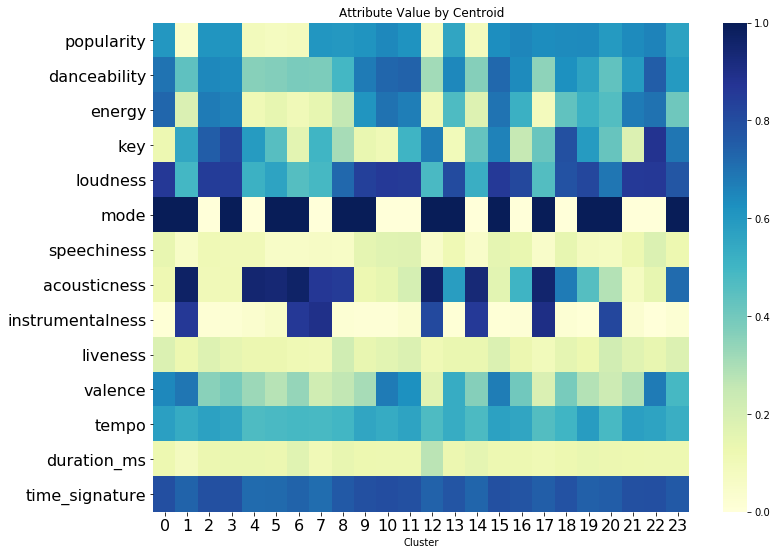

In [61]:
plt.figure(figsize = (12, 9))
ax = sns.heatmap(cluster_centroids.T, cmap = 'YlGnBu')
ax.set_xlabel("Cluster")
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)
ax.set_title("Attribute Value by Centroid")
plt.show()

In [96]:
# for i, row in cluster_centroids.iterrows():
#     row.sort_values(ascending=False).plot.bar(title=f'Cluster {i}')
#     plt.show()

# Prediction

In [63]:
result = kmeans_predictor.predict(df_array)

In [70]:
cluster_labels = [r.label['closest_cluster'].float32_tensor.values[0] for r in result]

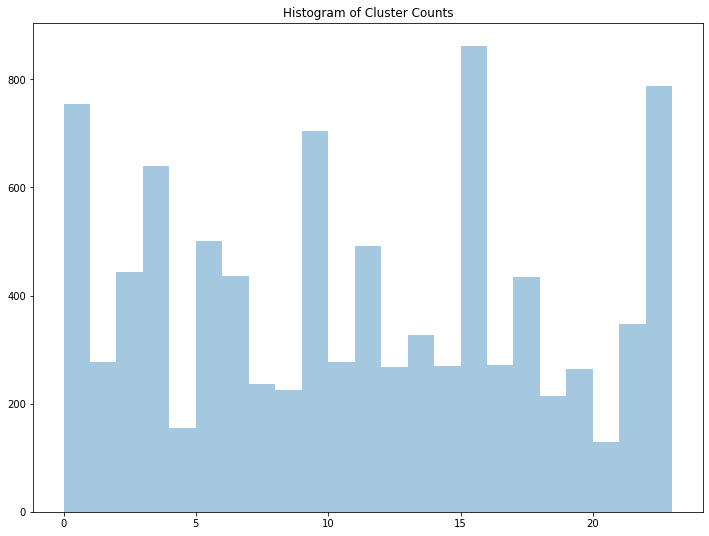

In [66]:
ax=plt.subplots(figsize=(12,9))
ax=sns.distplot(cluster_labels, kde=False)
title="Histogram of Cluster Counts"
ax.set_title(title, fontsize=12)
plt.show()

In [71]:
df_full['labels']=list(map(int, cluster_labels))
df_full.head()

,artist_name,track_name,track_id,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,labels
0,Post Malone,Circles,21jGcNKet2qwijlDFuPiPb,99,0.695,0.762,0,-3.497,1,0.0395,0.1920,0.002440,0.0863,0.5530,120.042,215280,4,0
1,Travis Scott,HIGHEST IN THE ROOM,3eekarcy7kvN4yt5ZFzltW,98,0.598,0.427,7,-8.764,0,0.0317,0.0546,0.000006,0.2100,0.0605,76.469,175721,4,2
2,Juice WRLD,Bandit (with YoungBoy Never Broke Again),6Gg1gjgKi2AK4e0qzsR7sd,93,0.474,0.631,5,-5.884,0,0.3430,0.0687,0.000000,0.1320,0.4250,180.051,189323,4,21
3,Arizona Zervas,ROXANNE,696DnlkuDOXcMAnKlTgXXK,97,0.621,0.601,6,-5.616,0,0.1480,0.0522,0.000000,0.4600,0.4570,116.735,163636,5,11
4,Selena Gomez,Lose You To Love Me,1HfMVBKM75vxSfsQ5VefZ5,98,0.505,0.340,4,-9.005,1,0.0438,0.5760,0.000000,0.2100,0.0916,101.993,206459,4,8


In [74]:
# Looking at songs by cluster

In [76]:
df_full[df_full['labels']==0]

,artist_name,track_name,track_id,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,labels
0,Post Malone,Circles,21jGcNKet2qwijlDFuPiPb,99,0.695,0.762,0,-3.497,1,0.0395,0.192000,0.002440,0.0863,0.553,120.042,215280,4,0
24,Kanye West,Follow God,2QpGZOhTCHHiKmpSO9FW4h,92,0.529,0.900,1,-3.503,1,0.4180,0.000248,0.000012,0.0426,0.434,180.291,104591,4,0
28,Harry Styles,Watermelon Sugar,1e9oZCCiX42nJl0AcqriVo,91,0.548,0.816,0,-4.209,1,0.0465,0.122000,0.000000,0.3350,0.557,95.390,174000,4,0
40,Chance the Rapper,Hot Shower,00ko9WaS4jOX1kEk3gvHjf,85,0.897,0.522,2,-7.578,1,0.3740,0.001600,0.000000,0.0554,0.623,149.986,225924,4,0
49,Bad Bunny,Vete,5DxXgozhkPLgrbKFY91w0c,92,0.886,0.672,1,-4.394,1,0.1880,0.036300,0.000009,0.1010,0.526,91.976,192024,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9288,Josh A,Outbreak,3RcUIeBuEUGdnWtjAiXatI,57,0.690,0.887,1,-4.971,1,0.3150,0.081300,0.000000,0.1740,0.761,152.109,134215,4,0
9291,Kameron Marlowe,Take You Up On It,2ERap8RaypGXMkZW21hO5Y,54,0.589,0.895,2,-3.139,1,0.0582,0.069800,0.000000,0.1580,0.770,110.733,212833,4,0
9308,The Band CAMINO,Something To Hold On To,0NYWOdPc325HwMNLdDTn0P,54,0.473,0.868,1,-3.962,1,0.0716,0.000396,0.008660,0.0763,0.626,75.983,220371,4,0
9315,Griselda,Cruiser Weight Coke,5miZ7ZA8XJX0zGaTmtyzXn,55,0.728,0.809,3,-5.678,1,0.4350,0.257000,0.000000,0.3810,0.599,130.018,232951,4,0


In [ ]:
# Predict cluster of new song

In [129]:
new_song = pd.DataFrame({'popularity':[90], 'danceability':[0.695], 'energy':[0.601], 'key':[5], 'loudness':[-5.616], 'mode':[0], 'speechiness':[0.1480], 'acousticness':[0.1920], 'instrumentalness':[0.002440], 'liveness':[0.1263], 'valence':[0.4570], 'tempo':[101.993], 'duration_ms':[189323], 'time_signature':[5]})

In [130]:
new_song_scaled = pd.DataFrame(scaler.transform(new_song))
new_song_array = new_song_scaled.to_numpy().astype(np.float32)
new_song_result = kmeans_predictor.predict(new_song_array)
new_song_cluster = int(new_song_result[0].label['closest_cluster'].float32_tensor.values[0])

In [131]:
print(f'This song belongs to cluster {new_song_cluster}')

This song belongs to cluster 11


In [ ]:
# Deleting endpoint

In [ ]:
sagemaker.Session().delete_endpoint(kmeans_predictor.endpoint)